## COVID-19 em Niterói - Cálculo do número de reprodução efetivo (R$_t$)

Esse tutorial visa a implementação de um código capaz de calcular o número de reprodução efetivo (R$_t$) da COVID-19 para a cidade de Niterói (RJ). A abordagem pode ser facilmente estendida para qualquer base de dados disponível.

Esse código usa como referência o trabalho de [Bettencourt e Ribeiro (2008)](https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0002185&type=printable) e uma adaptação da rotina implementada por [Kevin](https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb)

## Uma revisão teórica

### Distribuição de Poisson

Na teoria da probabilidade e na estatística, a distribuição de Poisson é uma distribuição de probabilidade de variável aleatória discreta que expressa a probabilidade de uma série de eventos ocorrer num certo período de tempo se estes eventos ocorrem independentemente de quando ocorreu o último evento. A probabilidade de que existam exatamente $k$ ocorrências ($k \geq 0$) é:

$P(k|\lambda) = \dfrac{e^{-\lambda}\lambda^k}{k!}$

Na equação anterior, $\lambda$ é o número *esperado* de ocorrências. Esse tipo de distribuição é bastante utilizado na área de saúde para prever o avanço de uma determinada doença em uma população. Utiliza-se uma distribuição de *probabilidades* pois a taxa com que uma doença avança sobre uma população depende de diversos fatores, alguns deles de fácil quantificação, outros de medição mais complicada - sendo, portanto, uma **predição** de um cenário que, obviamente, virá carregada de incertezas.

Felizmente, nós não precisamos nos preocupar em implementar essa distribuição. O Python já traz essa função no pacote `scipy.stats`. Tudo que você precisa fornecer à essa função (`scipy.stats.poisson.pmf`) são os parâmetros $\lambda$ e $k$:

### Número básico de reprodução (R$_0$) e número efetivo de reprodução (R$_t$):

Em epidemiologia, uma das maneiras de se mensurar o avanço de determinada doença é através do cálculo do **número básico de reprodução (R$_0$)**, que mede quantos indíviduos de uma população totalmente suscetível um outro indivíduo que tem uma doença pode contaminar.

É importante frisar que o R$_0$ é uma variável "*irreal*" , no sentido de que ela é válida quando não há *nenhuma* medida de contenção por partes das autoridades. No caso da COVID-19, esse número só seria real se nós ignorássemos por completo a doença e continuássemos saindo às ruas normalmente, não houvesse medidas de higiene mais rígidas, não houvesse uso de máscaras etc.

Bom, já dá pra perceber que esse número está um pouco fora da realidade, não é? O ideal seria medir essa probabilidade de contaminação através de um número que conseguisse se adequar mais à realidade, isto é, onde medidas de contenção serão tomadas, mesmo que mínimas. É o caso do **número efetivo de reprodução (R$_t$)**.

O que o trabalho de Bettencourt e Ribeiro (2008) buscou fazer é estabelecer uma **relação matemática** entre R$_t$ e $\lambda$, obtida na forma:

$\lambda =  k_{t-1}e^{\gamma(R_t-1)}$

Ou seja: o número *esperado* de casos ($\lambda$) depende do número de casos **confirmados** no momento imediatamente anterior à medição ($k_{t-1}$), do número efetivo de reprodução (R$_t$) e do **período de infecção ($\gamma^{-1}$)**, que é o período que o indivíduo fica infectado com a doença (no caso da COVID-19, esse período é de 7 dias).

Aconselho fortemente que o leitor dê uma olhada no artigo de [Bettencourt e Ribeiro (2008)](https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0002185&type=printable) caso esteja curioso sobre a derivação matemática da relação anterior. Além disso, conhecimentos extras sobre distribuições de probabilidade ajudam nesse momento =)

## Implementação do código

### Primeiro passo: chamando as bibliotecas

Vamos necessitar de quatro bibliotecas para esse código:

* **Pandas**, um pacote magnífico para lidar com estrutura de dados em tabelas;
* **Numpy**, um pacote para operações matemáticas;
* **Scipy.stats**, módulo estatístico do pacote Scipy, para fazer análises estatísticas;
* **Matplotlib.pyplot**, pacote mais utilizado para gerar gráfico.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

### Segundo passo: ler o arquivo `.csv` com os dados de Niterói

A leitura do arquivo será feita pelo pacote **Pandas**, utilizando a função `read_csv`. Atente para o separador utilizado (;), para o argumento `header = 0`, que diz que a primeira linha de cada coluna é o cabeçalho, e para os nomes das colunas dados. Caso você opte por usar outra base de dados (de outra cidade) ou atualizar o arquivo com mais colunas, deverá colocar mais uma entrada no argumento *names*.

In [2]:
df = pd.read_csv("Dados_COVID_Niteroi.csv", sep = ';', header = 0,
                 names = ['Date', 'Total cases', 'New cases', 'Total deaths', 'New deaths'])

Como a primeira coluna desse DataFrame são os dias, precisamos transformar esses dados em valores 'de data', para que o Pyhton consiga fazer os cálculos necessários posteriormente, entendendo que esses dados não são 'numéricos'. 

In [3]:
dias = pd.to_datetime(df['Date'])

## Terceiro passo: geração das distribuições de probabilidade

Agora é o momento de efetuar nossos cálculos. Vamos em etapas:

* Vamos criar um espaço linear contendo diferentes valores de R$_t$ para serem inseridos na equação de cálculo de $\lambda$. Isso nos dará uma possibilidade enorme de diferentes valores de $\lambda$ para uma infinidade de valores de R$_t$, indo de um valor mínimo (0,0) até um valor máximo (R$_{t,máx}$):

In [7]:
Rt_max = 12.0 #Aqui poderia ser qualquer valor muito grande - é quase impossível um Rt igual à 12.

In [5]:
Rt = np.linspace(0.0, Rt_max, 500)

* Agora, vamos definir o valor de $\gamma$. Lembrando que o período de infecção ($\gamma^{-1}$) = 7, então $\gamma = 1/7$:

In [6]:
gamma = 1/7

* Agora, lembra que a fórmula depende do número de casos diários (k)? Então, esse é o momento de selecionar essa coluna no nosso DataFrame. Pra isso, vamos transformá-la em *array*, para podermos fazer as operações de aplicação da função densidade de probabilidade de Poisson:

In [8]:
total_cases = np.array(df['Total cases'])

* Vamos agora fazer o cálculo dos valores de $\lambda$:

In [9]:
lam = total_cases[:-1] * np.exp(gamma * (Rt[:, None] - 1))

Duas considerações importantes na fórmula anterior:
* `total_cases[:-1]` significa que pegaremos todos os valores do vetor `total_cases`, *exceto o último*. Faremos isso porque se nós temos N entradas para o total de casos, nós teremos N-1 valores de lambda, já que o R$_t$ para o primeiro dia de pandemia não pode ser estimado (incerteza muito grande - $\lambda$ depende da medida anterior);

* Transformei o espaço linear `Rt` em uma 'coluna', fazendo `Rt[:,None]`, para não dar erro no cálculo.

Hora de calcular a função densidade de probabilidade de Poisson para o conjunto de dados (`total_cases` e os valores de `lam` calculados):

In [11]:
Poisson_Rt = ss.poisson.pmf(total_cases[1:], lam)

Lembrando que usamos `total_cases[1:]` porque queremos todos os valores da coluna dos casos totais **menos o primeiro dia**, que nós não temos como estimar. Por isso ele não pode entrar na função para a distribuição de probabilidades (não há probabilidade associada a ele).

* O que o `Poisson_Rt` nos deu foram todas as **probabilidades** possíveis de se obter diferentes valores de R$_t$ associados aos números de casos totais reportados dia-a-dia. Como saber então qual o valor de R$_t$ mais provável?

Bom, como teremos uma **curva** que apresenta um **pico**, é possível supor que o pico dessa curva representa o valor de R$_t$ mais provável de acontecer (ou seja, com maior valor de probabilidade).

Mas uma maneira mais precisa de se fazer esse cálculo é considerar que cada probabilidade associada aos diferentes valores de R$_t$ representa um **peso** no cálculo do R$_t$. Em outras palavras: valores de R$_t$ com probabilidades baixas são menos prováveis de acontecer. Dependendo do formato da curva, o valor mais exato do R$_t$ pode não ser exatamente no pico - às vezes um pouco antes ou um pouco depois.

Assim, podemos fazer um **produto acumulado** (`.cumprod()`) nos valores do vetor coluna `Poisson_Rt` para saber exatamente o valor mais provável (R$_t$ do pico da curva):

In [13]:
Probs = Poisson_Rt.cumprod(axis=1)

Atenção ao `axis=1`. Ele indica que você fará o produto acumulado descendo na mesma coluna, ok?

Vamos transformar esse objeto `Probs` num dataframe? Isso é interessante para que a gente possa fazer todas as funcionalidades que o pacote **Pandas** nos permite:

In [14]:
Probs = pd.DataFrame(data = Probs, index = Rt)

Olha que interessante: ao escrever `index = Rt`, nós forçamos uma troca nos índices da coluna. Ao invés deles começarem na ordem crescente 0, 1...N, eles receberão, em sequência, os valores de R$_t$ designados para iniciarmos os nossos cálculos.

O que precisamos fazer agora? Achar o índice do DataFrame `Probs` que corresponde ao **valor máximo** (`.idxmax()`) desse vetor coluna (ou seja, a maior probabilidade acumulada):

In [16]:
Rt_prov = Probs.idxmax(axis = 0)

* Agora, é só plotar a evolução do R$_t$, dia-a-dia, para a cidade de Niterói:

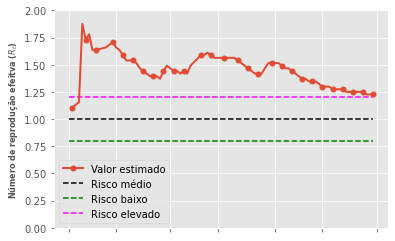

In [18]:
plt.style.use('ggplot') # estilo diferente para o gráfico
plt.plot(dias[1:], Rt_prov, 'o-', lw=2, markersize = 5, markevery = 3, label = 'Valor estimado')
plt.ylim([0.0,2.0])
plt.ylabel('Número de reprodução efeitva ($R_t$)', fontweight = 'bold', fontsize = 8)
plt.gca().axes.get_xaxis().set_ticklabels([])
plt.hlines(1.0,dias.min(), dias.max(), linestyle = 'dashed', lw = 1.5, label = 'Risco médio')
plt.hlines(0.8,dias.min(), dias.max(), colors = 'green', linestyle = 'dashed', lw = 1.5, label = 'Risco baixo')
plt.hlines(1.2,dias.min(), dias.max(), colors = 'magenta', linestyle = 'dashed', lw = 1.5, label = 'Risco elevado' )
plt.legend(loc = 'best')